### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 13 июня 2022, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 13 июня, -4 балла после 08:30 20 июня, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0422, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

1) MSE $$ - \frac{\partial L(F_{k-1}(x_i), y_i)}{\partial F_{k-1}(x_i)} = - \frac{\partial ((y_i - F_{k-1}(x_i)) ^ 2)}{\partial F_{k-1}(x_i)} = 2 (y_i - F_{k-1}(x_i))$$

2) Экспоненциальная $$ - \frac{\partial L(F_{k-1}(x_i), y_i)}{\partial F_{k-1}(x_i)} = - \frac{\partial (exp( -F_{k-1}(x_i) y_i))}{\partial F_{k-1}(x_i)} = y_i exp( -y_i F_{k-1}(x_i))$$

3) Логистическая $$ - \frac{\partial L(F_{k-1}(x_i), y_i)}{\partial F_{k-1}(x_i)} = - \frac{\partial (\log (1 + exp( - y_i F_{k-1}(x_i))))}{\partial F_{k-1}(x_i)} = \frac{y_i exp( - y_i F_{k-1}(x_i))}{1 + exp( - y_i F_{k-1}(x_i))} = \frac{y_i}{1 + exp(y_i F_{k-1}(x_i))}$$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [430]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [431]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='MSE', learning_rate=0.1, n_estimators=100, colsample=1.0, subsample=1.0, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        self.models = []
        self.features = []
        
        if init_model is not None:
            init_model.fit(X,y)
            sum_loss = init_model.predict(X).astype('float64')
            self.models.append(init_model)
            self.features.append(np.arange(X.shape[1]))
            
        else:
            sum_loss = np.zeros(y.size).astype('float64')
        
        n = int(self.subsample * X.shape[0])
        m = int(self.colsample * X.shape[1])
            
        for i in range(self.n_estimators):
            model = base_model(*self.args, **self.kwargs)
            
            indx_n = np.random.choice(X.shape[0], n, replace=False)
            indx_m = np.random.choice(X.shape[1], m, replace=False)
            
            self.features.append(indx_m)
            
            if self.loss == 'MSE':
                preds = 2 * (y[indx_n] - sum_loss[indx_n])

            elif self.loss == 'Exp':
                preds =  y[indx_n] * np.exp(-y[indx_n] * sum_loss[indx_n])

            elif self.loss == 'Log':
                preds = y[indx_n] / (1 + np.exp(y[indx_n] * sum_loss[indx_n]))
                
                
            model.fit(X[indx_n][:, indx_m], preds) 
            sum_loss +=  self.learning_rate * model.predict(X[:, indx_m])
            self.models.append(model)        

    def predict(self, X):
        predict = np.zeros(X.shape[0])
        for i, model in enumerate(self.models):
            predict += self.learning_rate * model.predict(X[:, self.features[i]])
        if self.loss == 'MSE':
            return np.around(predict)
        else:
            return predict > 0.5



In [432]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [433]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [434]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.7777777777777778
0.9444444444444444


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [445]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [446]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [447]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

kfold = KFold(n_splits = 3, shuffle = True)

In [448]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [449]:
acc = []
for i in range(1, 500, 5):
    preds = 0
    my_clf = MyGradientBoostingClassifier(n_estimators=i)
    for ind_train, ind_test in kfold.split(X_train, y_train):
        X_train_, X_test_, y_train_, y_test_ = X_train[ind_train], X_train[ind_test], y_train[ind_train], y_train[ind_test]
        my_clf.fit(X_train_, y_train_)
        preds += accuracy_score(y_pred=my_clf.predict(X_test_), y_true=y_test_)
    acc.append(preds / 3)
        

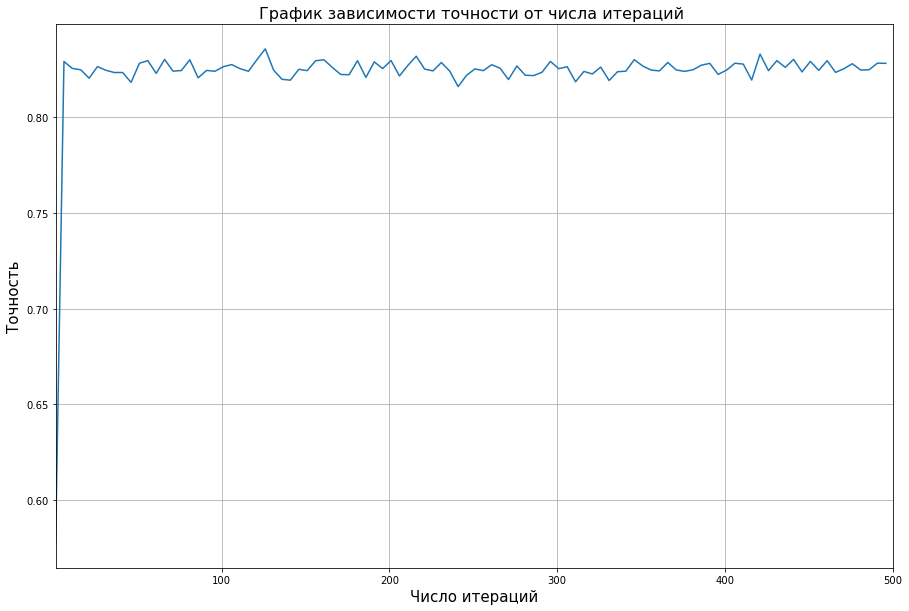

In [450]:
fig = plt.figure(figsize = (15, 10))
plt.title('График зависимости точности от числа итераций ',fontsize=16)
plt.xlabel('Число итераций', fontsize=15)
plt.ylabel('Точность', fontsize=15)
plt.xlim([1, 500])
plt.plot(np.arange(1, 500, 5), acc)
plt.grid(True)

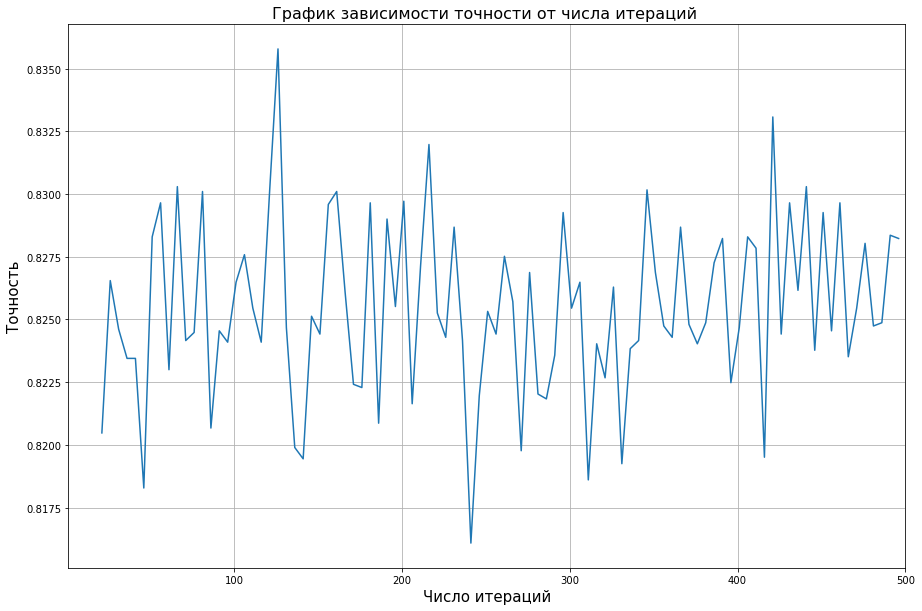

In [451]:
fig = plt.figure(figsize = (15, 10))
plt.title('График зависимости точности от числа итераций ',fontsize=16)
plt.xlabel('Число итераций', fontsize=15)
plt.ylabel('Точность', fontsize=15)
plt.xlim([1, 500])
plt.plot(np.arange(21, 500, 5), acc[4:])
plt.grid(True)

In [452]:
iterat = np.arange(1, 500, 5)
best_iter = iterat[np.argmax(acc)]
print(best_iter)

126


In [453]:
kfold = KFold(n_splits = 5, shuffle = True)

Подбираем функцию потерь

In [454]:
acc = []
loss = ['MSE', 'Exp', 'Log']
for i in ['MSE', 'Exp', 'Log']:
    preds = 0
    my_clf = MyGradientBoostingClassifier(loss=i)
    for ind_train, ind_test in kfold.split(X_train, y_train):
        X_train_, X_test_, y_train_, y_test_ = X_train[ind_train], X_train[ind_test], y_train[ind_train], y_train[ind_test]
        my_clf.fit(X_train_, y_train_)
        preds += accuracy_score(y_pred=my_clf.predict(X_test_), y_true=y_test_)
    acc.append(preds / 5)
print(acc)
best_loss = loss[np.argmax(acc)]
print(best_loss)

[0.8239018087855298, 0.8184754521963825, 0.8233850129198966]
MSE


Подбираем оптимальный шаг

In [455]:
acc = []
learning_rate = np.arange(0.1, 1.1, 0.1)
for lr in learning_rate:
    preds = 0
    my_clf = MyGradientBoostingClassifier(learning_rate=lr)
    for ind_train, ind_test in kfold.split(X_train, y_train):
        X_train_, X_test_, y_train_, y_test_ = X_train[ind_train], X_train[ind_test], y_train[ind_train], y_train[ind_test]
        my_clf.fit(X_train_, y_train_)
        preds += accuracy_score(y_pred=my_clf.predict(X_test_), y_true=y_test_)
    acc.append(preds / 5)
print(acc)
best_lr = learning_rate[np.argmax(acc)]
print(best_lr)

[0.8319121447028422, 0.827002583979328, 0.8290697674418606, 0.823062015503876, 0.8257751937984497, 0.8239664082687337, 0.8168604651162792, 0.812532299741602, 0.8007751937984496, 0.5266795865633075]
0.1


Подбираем процент рандомных признаков

In [456]:
acc = []
percent = np.arange(0.2, 1.1, 0.1)
for p in percent:
    preds = 0
    my_clf = MyGradientBoostingClassifier(learning_rate=0.1, colsample=p)
    for ind_train, ind_test in kfold.split(X_train, y_train):
        X_train_, X_test_, y_train_, y_test_ = X_train[ind_train], X_train[ind_test], y_train[ind_train], y_train[ind_test]
        my_clf.fit(X_train_, y_train_)
        preds += accuracy_score(y_pred=my_clf.predict(X_test_), y_true=y_test_)
    acc.append(preds / 5)
print(acc)
best_p = percent[np.argmax(acc)]
print(best_p)

[0.682170542635659, 0.7279715762273902, 0.8065245478036175, 0.8510981912144702, 0.8529069767441861, 0.8729328165374678, 0.8679586563307493, 0.8568475452196382, 0.8284883720930234]
0.7000000000000002


Подбираем процент рандомных признаков

In [457]:
acc = []
percent = np.arange(0.1, 1.1, 0.1)
for p in percent:
    preds = 0
    my_clf = MyGradientBoostingClassifier(learning_rate=0.1, colsample=0.7, subsample=p)
    for ind_train, ind_test in kfold.split(X_train, y_train):
        X_train_, X_test_, y_train_, y_test_ = X_train[ind_train], X_train[ind_test], y_train[ind_train], y_train[ind_test]
        my_clf.fit(X_train_, y_train_)
        preds += accuracy_score(y_pred=my_clf.predict(X_test_), y_true=y_test_)
    acc.append(preds / 5)
print(acc)
best_p = percent[np.argmax(acc)]
print(best_p)

[0.6016795865633074, 0.8083333333333333, 0.850516795865633, 0.8608527131782946, 0.8702196382428941, 0.8715116279069768, 0.8700904392764857, 0.8662790697674418, 0.8807493540051681, 0.8567183462532301]
0.9


Подбираем максимальную длину деревьев

In [458]:
acc = []
depth = np.arange(1, 10)
for d in depth:
    preds = 0
    my_clf = MyGradientBoostingClassifier(learning_rate=0.1, colsample=0.7, subsample=0.9, max_depth=d)
    for ind_train, ind_test in kfold.split(X_train, y_train):
        X_train_, X_test_, y_train_, y_test_ = X_train[ind_train], X_train[ind_test], y_train[ind_train], y_train[ind_test]
        my_clf.fit(X_train_, y_train_)
        preds += accuracy_score(y_pred=my_clf.predict(X_test_), y_true=y_test_)
    acc.append(preds / 5)
print(acc)
best_d = depth[np.argmax(acc)]
print(best_d)

[0.8534237726098193, 0.8735142118863048, 0.8842377260981913, 0.8877906976744188, 0.8885012919896642, 0.8921188630490956, 0.8901808785529717, 0.8886304909560725, 0.8906330749354006]
6


Смотрим точность на тесте при оптимальных параметрах

In [460]:
my_clf = MyGradientBoostingClassifier(learning_rate=0.1, n_estimators=126, colsample=0.7, subsample=0.9, max_depth=6)
my_clf.fit(X_train, y_train)
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.8955426356589147

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [415]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [399]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [461]:
my_clf = MyGradientBoostingClassifier(learning_rate=0.1, colsample=0.7, subsample=0.9, max_depth=6)
my_clf.fit(X_train, y_train, base_model=RandomForestRegressor)
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.9025193798449612

In [463]:
preds = np.zeros(y_test.size, dtype=float)
for i in range(100):
    my_clf = MyGradientBoostingClassifier(learning_rate=0.1, n_estimators=20, colsample=0.7, subsample=0.3, max_depth=6)
    my_clf.fit(X_train, y_train, base_model=RandomForestRegressor)
    print(i, end=' ')
    preds += my_clf.predict(X_test)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [464]:
accuracy_score((preds/100).astype('int'), y_test)

0.8680232558139535

В первом пункте точность немного выросла, думаю, это связано с тем что RandomForestRegressor более мощный алгоритм.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [465]:
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.svm import SVC

In [466]:
my_clf = MyGradientBoostingClassifier(learning_rate=0.2, colsample=0.7, subsample=0.5)
my_clf.fit(X_train, y_train, init_model=LinearRegression())
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.6191860465116279

In [467]:
my_clf = MyGradientBoostingClassifier(learning_rate=0.2, colsample=0.7, subsample=0.5)
my_clf.fit(X_train, y_train, init_model=LogisticRegression(max_iter=500))
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.5689922480620155

In [468]:
my_clf = MyGradientBoostingClassifier(loss ='Exp', learning_rate=0.2, colsample=0.7, subsample=0.5)
my_clf.fit(X_train, y_train, init_model=LogisticRegression(max_iter=500))
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.7151162790697675

In [469]:
my_clf = MyGradientBoostingClassifier(loss ='Exp', learning_rate=0.2, colsample=0.7, subsample=0.5)
my_clf.fit(X_train, y_train, init_model=LinearRegression())
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.7166666666666667

In [470]:
my_clf = MyGradientBoostingClassifier(loss ='Log', learning_rate=0.2, colsample=0.7, subsample=0.5)
my_clf.fit(X_train, y_train, init_model=LogisticRegression(max_iter=500))
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.7565891472868217

In [471]:
my_clf = MyGradientBoostingClassifier(loss ='Log', learning_rate=0.2, colsample=0.7, subsample=0.5)
my_clf.fit(X_train, y_train, init_model=LinearRegression())
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.7463178294573644

In [472]:
my_clf = MyGradientBoostingClassifier(learning_rate=0.2, colsample=0.7, subsample=0.5)
my_clf.fit(X_train, y_train, init_model=SVC(kernel='linear',max_iter=1000))
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

c:\programdata\miniconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.548062015503876

In [473]:
my_clf = MyGradientBoostingClassifier(loss ='Exp', learning_rate=0.2, colsample=0.7, subsample=0.5)
my_clf.fit(X_train, y_train, init_model=SVC(kernel='linear',max_iter=1000))
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

c:\programdata\miniconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.6901162790697675

In [474]:
my_clf = MyGradientBoostingClassifier(loss ='Log', learning_rate=0.2, colsample=0.7, subsample=0.5)
my_clf.fit(X_train, y_train, init_model=SVC(kernel='linear',max_iter=1000))
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

c:\programdata\miniconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.6936046511627907

In [475]:
my_clf = MyGradientBoostingClassifier(learning_rate=0.2, colsample=0.7, subsample=0.5)
my_clf.fit(X_train, y_train, init_model=RandomForestRegressor())
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.5810077519379845

In [476]:
my_clf = MyGradientBoostingClassifier(loss ='Exp', learning_rate=0.2, colsample=0.7, subsample=0.5)
my_clf.fit(X_train, y_train, init_model=RandomForestRegressor())
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.7569767441860465

In [477]:
my_clf = MyGradientBoostingClassifier(loss ='Log', learning_rate=0.2, colsample=0.7, subsample=0.5)
my_clf.fit(X_train, y_train, init_model=RandomForestRegressor())
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.7703488372093024

In [478]:
my_clf = MyGradientBoostingClassifier(learning_rate=0.2, colsample=0.7, subsample=0.5)
my_clf.fit(X_train, y_train, init_model=RandomForestClassifier())
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.5800387596899225

In [479]:
my_clf = MyGradientBoostingClassifier(loss ='Exp', learning_rate=0.2, colsample=0.7, subsample=0.5)
my_clf.fit(X_train, y_train, init_model=RandomForestClassifier())
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.7972868217054263

In [480]:
my_clf = MyGradientBoostingClassifier(loss ='Log', learning_rate=0.2, colsample=0.7, subsample=0.5)
my_clf.fit(X_train, y_train, init_model=RandomForestClassifier())
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.8023255813953488

Не получилось улучшить качество, это связано с тем что началный алгоритм не должен быть слишком сложным, так как он хорошо обучается, а остальные модели учатся значительно слабее.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



Эта работа помогла разобраться с темой, спасибо)